# Objetivo

Avaliar o desempenho de uma rede neural artificial MLP e comparar com os modelos anteriores.

Links úteis:

- https://www.tensorflow.org/api_docs/python/tf/keras

- https://mlflow.org/blog/deep-learning-part-1

- https://mlflow.org/docs/latest/deep-learning/tensorflow/quickstart/quickstart_tensorflow.html

- https://mlflow.org/docs/latest/deep-learning/tensorflow/guide/index.html

- https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

- https://www.tensorflow.org/tutorials/keras/keras_tuner


Observação: os dois resultados obtidos em model.evaluate não são os mesmos.

# Pacotes

In [9]:
#!pip install tensorflow
#!pip install keras-tuner --upgrade

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from deltalake import DeltaTable, write_deltalake
import tensorflow as tf
from tensorflow import keras
import keras_tuner
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, recall_score, f1_score
import mlflow
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature

2025-01-25 16:03:14.096746: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 16:03:14.101415: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 16:03:14.116108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737831794.136916    6387 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737831794.141800    6387 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 16:03:14.162406: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Leitura da base v1 e filtro de variáveis

Variáveis com valor acumulado de importância em ~90% e pelo valor de IV.

In [2]:
dados = DeltaTable("../1.Variaveis/tmp/dados_pp_v1").to_pandas()
dados.drop(['__index_level_0__', 'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver', 
            'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Unknown', 'Gender_M',
            'Dependent_count'], axis=1, inplace=True)
dados.head()

,Customer_Age,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,vfm,pmcc,Income_Category_1.< 40k,Income_Category_2. >= 40k & < 60k,Income_Category_3. >= 60k & < 80k,Income_Category_4. >= 80k & < 120k,Income_Category_5. >= 120k,Education_Level_v2_1.Uneducated,Education_Level_v2_2.High School,Education_Level_v2_3.Graduate,Education_Level_v2_4.Post-Graduate,Attrition_Flag,type
0,-0.784196,1.403132,-1.337898,0.498943,0.963894,0.282975,-0.328225,-0.175537,-0.421450,1,0,0,0,0,0,0,1,0,0,Treino
1,0.720070,-0.525933,0.641818,1.408428,-0.165769,-1.527806,-0.194304,-0.208685,-1.054789,0,0,0,1,0,0,0,1,0,0,Treino
2,1.346848,-0.525933,-0.348040,0.498943,0.864865,0.894171,0.056797,-0.571459,-0.686436,0,0,0,1,0,0,0,0,1,0,Treino
3,0.218648,-0.525933,0.641818,-1.320028,-0.412731,0.369637,0.851953,0.252749,2.406712,1,0,0,0,0,0,0,1,0,0,Treino
4,-2.539173,0.117089,1.631675,1.408428,-0.858972,0.346832,-1.144306,-0.064053,-0.071911,1,0,0,0,0,1,0,0,0,0,Treino


Exporto os dados em csv para testar a rede neural no Google Colab, porque no ambiente virtual existem algumas inconsistências no método model.evaluate().

In [78]:
dados.to_csv(os.getcwd() + '/dados_colab.csv')

## Separa bases

In [3]:
dados_treino = dados[dados.type == 'Treino'].drop(['type'], axis=1)
dados_val = dados[dados.type == 'Validacao'].drop(['type'], axis=1)

In [4]:
X_treino = dados_treino.drop(['Attrition_Flag'], axis=1)
y_treino = dados_treino['Attrition_Flag']

X_val = dados_val.drop(['Attrition_Flag'], axis=1)
y_val = dados_val['Attrition_Flag']

In [5]:
X_treino_new = X_treino.rename(columns={'Income_Category_1.< 40k': 'Income_Category_1.40k',
                                        'Income_Category_2. >= 40k & < 60k': 'Income_Category_2.40k_60k',
                                        'Income_Category_3. >= 60k & < 80k': 'Income_Category_3.60k_80k',
                                        'Income_Category_4. >= 80k & < 120k': 'Income_Category_4.80k_120k',
                                        'Income_Category_5. >= 120k': 'Income_Category_5.120k'
                                        })

X_val_new = X_val.rename(columns={'Income_Category_1.< 40k': 'Income_Category_1.40k',
                                        'Income_Category_2. >= 40k & < 60k': 'Income_Category_2.40k_60k',
                                        'Income_Category_3. >= 60k & < 80k': 'Income_Category_3.60k_80k',
                                        'Income_Category_4. >= 80k & < 120k': 'Income_Category_4.80k_120k',
                                        'Income_Category_5. >= 120k': 'Income_Category_5.120k'
                                        })

In [6]:
X_treino2, X_teste2, y_treino2, y_teste2 = train_test_split(X_treino_new, y_treino, test_size=.40, stratify=y_treino, random_state=1234)
y_treino2.value_counts(), y_teste2.value_counts()

(Attrition_Flag
 0    3684
 1     705
 Name: count, dtype: int64,
 Attrition_Flag
 0    2456
 1     470
 Name: count, dtype: int64)

In [7]:
X_treino2.shape

(4389, 18)

In [8]:
X_treino2.dtypes

Customer_Age                          float64
Total_Relationship_Count              float64
Months_Inactive_12_mon                float64
Contacts_Count_12_mon                 float64
Total_Revolving_Bal                   float64
Total_Amt_Chng_Q4_Q1                  float64
Total_Ct_Chng_Q4_Q1                   float64
vfm                                   float64
pmcc                                  float64
Income_Category_1.40k                   int32
Income_Category_2.40k_60k               int32
Income_Category_3.60k_80k               int32
Income_Category_4.80k_120k              int32
Income_Category_5.120k                  int32
Education_Level_v2_1.Uneducated         int32
Education_Level_v2_2.High School        int32
Education_Level_v2_3.Graduate           int32
Education_Level_v2_4.Post-Graduate      int32
dtype: object

# Sequential API

In [7]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(10, activation='tanh', input_shape=X_treino2.shape[1:]),
        #keras.layers.Dropout(rate=.2),
        keras.layers.Dense(10, activation='tanh'),
        #keras.layers.Dropout(rate=.2),
        keras.layers.Dense(10, activation='tanh'),
        #keras.layers.Dropout(rate=.2),
        keras.layers.Dense(10, activation='tanh'),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-24 18:41:42.532342: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531 (2.07 KB)

 Trainable params: 531 (2.07 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=[keras.metrics.AUC(curve='PR')])
              #metrics=[keras.metrics.AUC(curve='PR'), tf.keras.metrics.F1Score, tf.keras.metrics.Precision, tf.keras.metrics.Recall])

In [13]:
X_treino2.shape[0]/50

87.78

In [10]:
# Callback que salva os pontos de verificação do modelo no final de cada época. Salva o modelo quando o desempenho no conjunto de validação for o melhor
checkpoint_cb = keras.callbacks.ModelCheckpoint("modelo_tf_keras.h5", save_best_only=True)

# Callback que interrompe o treinamento quando não calcular nenhum progresso na validação 
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_treino2, y_treino2, epochs=150,validation_data=(X_teste2, y_teste2), batch_size=32, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/150
105/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.1957 - loss: 0.6260 

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.1921 - loss: 0.6069 - val_auc: 0.2246 - val_loss: 0.4506
Epoch 2/150
124/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.2470 - loss: 0.4449

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.2464 - loss: 0.4441 - val_auc: 0.2987 - val_loss: 0.4174
Epoch 3/150
132/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.2760 - loss: 0.4114

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.2783 - loss: 0.4115 - val_auc: 0.3740 - val_loss: 0.3986
Epoch 4/150
113/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.3713 - loss: 0.4025

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.3759 - loss: 0.4011 - val_auc: 0.4412 - val_loss: 0.3809
Epoch 5/150
117/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.4292 - loss: 0.3693

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.4340 - loss: 0.3703 - val_auc: 0.4890 - val_loss: 0.3643
Epoch 6/150
116/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.5166 - loss: 0.3533

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.5147 - loss: 0.3546 - val_auc: 0.5240 - val_loss: 0.3501
Epoch 7/150
118/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.5526 - loss: 0.3542

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.5517 - loss: 0.3531 - val_auc: 0.5506 - val_loss: 0.3385
Epoch 8/150
130/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.5766 - loss: 0.3298

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.5759 - loss: 0.3302 - val_auc: 0.5694 - val_loss: 0.3298
Epoch 9/150
121/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.5525 - loss: 0.3391

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.5564 - loss: 0.3374 - val_auc: 0.5841 - val_loss: 0.3235
Epoch 10/150
130/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.5735 - loss: 0.3264

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.5754 - loss: 0.3260 - val_auc: 0.5946 - val_loss: 0.3190
Epoch 11/150
120/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6044 - loss: 0.3151

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6056 - loss: 0.3153 - val_auc: 0.6034 - val_loss: 0.3151
Epoch 12/150
131/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6002 - loss: 0.3165

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6015 - loss: 0.3161 - val_auc: 0.6101 - val_loss: 0.3122
Epoch 13/150
129/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6445 - loss: 0.3168

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6436 - loss: 0.3162 - val_auc: 0.6161 - val_loss: 0.3100
Epoch 14/150
115/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6668 - loss: 0.3040

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6615 - loss: 0.3041 - val_auc: 0.6205 - val_loss: 0.3081
Epoch 15/150
131/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6599 - loss: 0.2890

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6587 - loss: 0.2898 - val_auc: 0.6247 - val_loss: 0.3064
Epoch 16/150
129/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6499 - loss: 0.3065

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6496 - loss: 0.3062 - val_auc: 0.6270 - val_loss: 0.3050
Epoch 17/150
135/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6637 - loss: 0.3049

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6633 - loss: 0.3047 - val_auc: 0.6307 - val_loss: 0.3039
Epoch 18/150
130/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6276 - loss: 0.3208

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6291 - loss: 0.3193 - val_auc: 0.6327 - val_loss: 0.3027
Epoch 19/150
128/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6654 - loss: 0.2951

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6648 - loss: 0.2952 - val_auc: 0.6349 - val_loss: 0.3016
Epoch 20/150
116/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6849 - loss: 0.2829

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6809 - loss: 0.2848 - val_auc: 0.6376 - val_loss: 0.3006
Epoch 21/150
112/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6789 - loss: 0.2862

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6747 - loss: 0.2884 - val_auc: 0.6388 - val_loss: 0.2998
Epoch 22/150
122/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6770 - loss: 0.2913

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6757 - loss: 0.2912 - val_auc: 0.6408 - val_loss: 0.2988
Epoch 23/150
112/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6548 - loss: 0.2873

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6550 - loss: 0.2886 - val_auc: 0.6423 - val_loss: 0.2981
Epoch 24/150
129/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6804 - loss: 0.2959

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.6793 - loss: 0.2955 - val_auc: 0.6441 - val_loss: 0.2973
Epoch 25/150
112/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6642 - loss: 0.3054

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6654 - loss: 0.3026 - val_auc: 0.6449 - val_loss: 0.2967
Epoch 26/150
113/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6557 - loss: 0.2939

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6585 - loss: 0.2929 - val_auc: 0.6461 - val_loss: 0.2961
Epoch 27/150
109/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6577 - loss: 0.2985

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6608 - loss: 0.2963 - val_auc: 0.6475 - val_loss: 0.2956
Epoch 28/150
111/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6848 - loss: 0.2938

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6801 - loss: 0.2928 - val_auc: 0.6479 - val_loss: 0.2950
Epoch 29/150
115/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6690 - loss: 0.2916

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6685 - loss: 0.2907 - val_auc: 0.6485 - val_loss: 0.2946
Epoch 30/150
116/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6619 - loss: 0.2922

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6643 - loss: 0.2910 - val_auc: 0.6495 - val_loss: 0.2940
Epoch 31/150
108/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6715 - loss: 0.2801

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6720 - loss: 0.2807 - val_auc: 0.6499 - val_loss: 0.2935
Epoch 32/150
111/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7032 - loss: 0.2606

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6978 - loss: 0.2646 - val_auc: 0.6501 - val_loss: 0.2935
Epoch 33/150
116/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6566 - loss: 0.2774

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6596 - loss: 0.2781 - val_auc: 0.6505 - val_loss: 0.2932
Epoch 34/150
110/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6860 - loss: 0.2807

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6845 - loss: 0.2809 - val_auc: 0.6513 - val_loss: 0.2927
Epoch 35/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6848 - loss: 0.2854 - val_auc: 0.6511 - val_loss: 0.2928
Epoch 36/150
123/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6822 - loss: 0.2680

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6821 - loss: 0.2689 - val_auc: 0.6523 - val_loss: 0.2921
Epoch 37/150
119/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6762 - loss: 0.2814

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6763 - loss: 0.2811 - val_auc: 0.6525 - val_loss: 0.2918
Epoch 38/150
110/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6652 - loss: 0.2812

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6679 - loss: 0.2810 - val_auc: 0.6535 - val_loss: 0.2915
Epoch 39/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6753 - loss: 0.2907 - val_auc: 0.6532 - val_loss: 0.2918
Epoch 40/150
122/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7190 - loss: 0.2890

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7148 - loss: 0.2880 - val_auc: 0.6538 - val_loss: 0.2911
Epoch 41/150
137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6972 - loss: 0.2692

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6969 - loss: 0.2693 - val_auc: 0.6534 - val_loss: 0.2909
Epoch 42/150
117/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6201 - loss: 0.3084

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6299 - loss: 0.3041 - val_auc: 0.6535 - val_loss: 0.2905
Epoch 43/150
117/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6700 - loss: 0.2713

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6733 - loss: 0.2721 - val_auc: 0.6538 - val_loss: 0.2904
Epoch 44/150
115/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7184 - loss: 0.2738

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7121 - loss: 0.2748 - val_auc: 0.6553 - val_loss: 0.2897
Epoch 45/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7127 - loss: 0.2735 - val_auc: 0.6560 - val_loss: 0.2897
Epoch 46/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6886 - loss: 0.2789 - val_auc: 0.6550 - val_loss: 0.2901
Epoch 47/150
123/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6976 - loss: 0.2748

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6965 - loss: 0.2751 - val_auc: 0.6565 - val_loss: 0.2891
Epoch 48/150
124/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7060 - loss: 0.2731

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7045 - loss: 0.2733 - val_auc: 0.6565 - val_loss: 0.2888
Epoch 49/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6752 - loss: 0.2767 - val_auc: 0.6560 - val_loss: 0.2889
Epoch 50/150
127/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7016 - loss: 0.2787

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7004 - loss: 0.2786 - val_auc: 0.6567 - val_loss: 0.2885
Epoch 51/150
126/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7126 - loss: 0.2808

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.7108 - loss: 0.2802 - val_auc: 0.6567 - val_loss: 0.2885
Epoch 52/150
123/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6887 - loss: 0.2668

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6886 - loss: 0.2678 - val_auc: 0.6575 - val_loss: 0.2881
Epoch 53/150
115/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6842 - loss: 0.2752

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6857 - loss: 0.2752 - val_auc: 0.6585 - val_loss: 0.2879
Epoch 54/150
121/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6843 - loss: 0.2672

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6855 - loss: 0.2679 - val_auc: 0.6584 - val_loss: 0.2877
Epoch 55/150
127/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6636 - loss: 0.2845

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.6661 - loss: 0.2837 - val_auc: 0.6592 - val_loss: 0.2874
Epoch 56/150
136/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7000 - loss: 0.2711

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6998 - loss: 0.2712 - val_auc: 0.6598 - val_loss: 0.2871
Epoch 57/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.7127 - loss: 0.2660 - val_auc: 0.6586 - val_loss: 0.2884
Epoch 58/150
130/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6828 - loss: 0.2720

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6834 - loss: 0.2721 - val_auc: 0.6592 - val_loss: 0.2868
Epoch 59/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6421 - loss: 0.2868 - val_auc: 0.6594 - val_loss: 0.2872
Epoch 60/150
134/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6993 - loss: 0.2825

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6990 - loss: 0.2822 - val_auc: 0.6592 - val_loss: 0.2866
Epoch 61/150
105/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6914 - loss: 0.2859

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6933 - loss: 0.2828 - val_auc: 0.6616 - val_loss: 0.2860
Epoch 62/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6832 - loss: 0.2685 - val_auc: 0.6610 - val_loss: 0.2861
Epoch 63/150
132/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6812 - loss: 0.2512

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6820 - loss: 0.2522 - val_auc: 0.6611 - val_loss: 0.2860
Epoch 64/150
130/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6437 - loss: 0.2840

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6471 - loss: 0.2831 - val_auc: 0.6620 - val_loss: 0.2857
Epoch 65/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.7198 - loss: 0.2647 - val_auc: 0.6617 - val_loss: 0.2858
Epoch 66/150
129/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7169 - loss: 0.2765

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7156 - loss: 0.2760 - val_auc: 0.6611 - val_loss: 0.2856
Epoch 67/150
120/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7081 - loss: 0.2617

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7056 - loss: 0.2633 - val_auc: 0.6615 - val_loss: 0.2849
Epoch 68/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6755 - loss: 0.2727 - val_auc: 0.6607 - val_loss: 0.2857
Epoch 69/150
132/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6809 - loss: 0.2949

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6817 - loss: 0.2936 - val_auc: 0.6621 - val_loss: 0.2845
Epoch 70/150
135/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6967 - loss: 0.2729

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.6967 - loss: 0.2728 - val_auc: 0.6625 - val_loss: 0.2842
Epoch 71/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7037 - loss: 0.2654 - val_auc: 0.6612 - val_loss: 0.2844
Epoch 72/150
112/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7307 - loss: 0.2614

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7243 - loss: 0.2629 - val_auc: 0.6625 - val_loss: 0.2839
Epoch 73/150
109/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6847 - loss: 0.2679

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6875 - loss: 0.2681 - val_auc: 0.6629 - val_loss: 0.2834
Epoch 74/150
127/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6589 - loss: 0.2718

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6624 - loss: 0.2716 - val_auc: 0.6635 - val_loss: 0.2833
Epoch 75/150
130/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6784 - loss: 0.2872

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6800 - loss: 0.2860 - val_auc: 0.6637 - val_loss: 0.2832
Epoch 76/150
131/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7138 - loss: 0.2627

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7132 - loss: 0.2629 - val_auc: 0.6639 - val_loss: 0.2830
Epoch 77/150
122/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6892 - loss: 0.2708

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6914 - loss: 0.2701 - val_auc: 0.6643 - val_loss: 0.2827
Epoch 78/150
124/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6764 - loss: 0.2700

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.6793 - loss: 0.2697 - val_auc: 0.6645 - val_loss: 0.2823
Epoch 79/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6744 - loss: 0.2707 - val_auc: 0.6642 - val_loss: 0.2827
Epoch 80/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7075 - loss: 0.2513 - val_auc: 0.6630 - val_loss: 0.2833
Epoch 81/150
120/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7236 - loss: 0.2484

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7214 - loss: 0.2507 - val_auc: 0.6650 - val_loss: 0.2815
Epoch 82/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7052 - loss: 0.2564 - val_auc: 0.6650 - val_loss: 0.2818
Epoch 83/150
136/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7234 - loss: 0.2645

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7231 - loss: 0.2645 - val_auc: 0.6661 - val_loss: 0.2813
Epoch 84/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7246 - loss: 0.2742 - val_auc: 0.6651 - val_loss: 0.2815
Epoch 85/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7003 - loss: 0.2748 - val_auc: 0.6651 - val_loss: 0.2815
Epoch 86/150
114/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7036 - loss: 0.2572

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7046 - loss: 0.2578 - val_auc: 0.6660 - val_loss: 0.2812
Epoch 87/150
114/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7296 - loss: 0.2603

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7277 - loss: 0.2606 - val_auc: 0.6671 - val_loss: 0.2806
Epoch 88/150
131/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7116 - loss: 0.2753

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7116 - loss: 0.2746 - val_auc: 0.6670 - val_loss: 0.2798
Epoch 89/150
127/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7062 - loss: 0.2632

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7067 - loss: 0.2630 - val_auc: 0.6659 - val_loss: 0.2797
Epoch 90/150
137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7196 - loss: 0.2640

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7195 - loss: 0.2640 - val_auc: 0.6680 - val_loss: 0.2789
Epoch 91/150
109/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7314 - loss: 0.2437

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7295 - loss: 0.2468 - val_auc: 0.6690 - val_loss: 0.2780
Epoch 92/150
133/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7147 - loss: 0.2623

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.7148 - loss: 0.2622 - val_auc: 0.6691 - val_loss: 0.2779
Epoch 93/150
130/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6900 - loss: 0.2609

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6919 - loss: 0.2608 - val_auc: 0.6688 - val_loss: 0.2775
Epoch 94/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6987 - loss: 0.2626 - val_auc: 0.6706 - val_loss: 0.2779
Epoch 95/150
118/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7022 - loss: 0.2592

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7049 - loss: 0.2591 - val_auc: 0.6695 - val_loss: 0.2762
Epoch 96/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7260 - loss: 0.2683 - val_auc: 0.6696 - val_loss: 0.2769
Epoch 97/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7177 - loss: 0.2692 - val_auc: 0.6694 - val_loss: 0.2764
Epoch 98/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7234 - loss: 0.2602 - val_auc: 0.6698 - val_loss: 0.2767
Epoch 99/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7306 - loss: 0.2390 - val_auc: 0.6688 - val_loss: 0.2763
Epoch 100/150
121/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7366 - loss: 0.2567

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7353 - loss: 0.2565 - val_auc: 0.6734 - val_loss: 0.2743
Epoch 101/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7154 - loss: 0.2518 - val_auc: 0.6727 - val_loss: 0.2744
Epoch 102/150
116/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7223 - loss: 0.2589

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7228 - loss: 0.2581 - val_auc: 0.6727 - val_loss: 0.2741
Epoch 103/150
121/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7083 - loss: 0.2643

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7106 - loss: 0.2632 - val_auc: 0.6748 - val_loss: 0.2734
Epoch 104/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7353 - loss: 0.2424

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7353 - loss: 0.2425 - val_auc: 0.6731 - val_loss: 0.2732
Epoch 105/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7164 - loss: 0.2521 - val_auc: 0.6745 - val_loss: 0.2735
Epoch 106/150
109/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7483 - loss: 0.2538

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7448 - loss: 0.2533 - val_auc: 0.6769 - val_loss: 0.2722
Epoch 107/150
137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7358 - loss: 0.2494

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7358 - loss: 0.2494 - val_auc: 0.6751 - val_loss: 0.2720
Epoch 108/150
125/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7235 - loss: 0.2521

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7247 - loss: 0.2517 - val_auc: 0.6769 - val_loss: 0.2711
Epoch 109/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.7005 - loss: 0.2532 - val_auc: 0.6766 - val_loss: 0.2715
Epoch 110/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7481 - loss: 0.2467 - val_auc: 0.6753 - val_loss: 0.2716
Epoch 111/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7353 - loss: 0.2630 - val_auc: 0.6757 - val_loss: 0.2732
Epoch 112/150
120/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7315 - loss: 0.2503

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7329 - loss: 0.2499 - val_auc: 0.6773 - val_loss: 0.2703
Epoch 113/150
119/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7250 - loss: 0.2391

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7270 - loss: 0.2401 - val_auc: 0.6799 - val_loss: 0.2697
Epoch 114/150
123/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7460 - loss: 0.2439

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.7461 - loss: 0.2438 - val_auc: 0.6795 - val_loss: 0.2691
Epoch 115/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7537 - loss: 0.2342 - val_auc: 0.6787 - val_loss: 0.2696
Epoch 116/150
125/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7319 - loss: 0.2486

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7330 - loss: 0.2481 - val_auc: 0.6804 - val_loss: 0.2691
Epoch 117/150
132/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7439 - loss: 0.2464

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7441 - loss: 0.2462 - val_auc: 0.6832 - val_loss: 0.2681
Epoch 118/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7490 - loss: 0.2378 - val_auc: 0.6825 - val_loss: 0.2682
Epoch 119/150
114/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7604 - loss: 0.2267

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7584 - loss: 0.2300 - val_auc: 0.6835 - val_loss: 0.2674
Epoch 120/150
123/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7906 - loss: 0.2274

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7866 - loss: 0.2287 - val_auc: 0.6850 - val_loss: 0.2667
Epoch 121/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7516 - loss: 0.2498 - val_auc: 0.6843 - val_loss: 0.2673
Epoch 122/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7538 - loss: 0.2325 - val_auc: 0.6843 - val_loss: 0.2682
Epoch 123/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7455 - loss: 0.2440

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7456 - loss: 0.2439 - val_auc: 0.6861 - val_loss: 0.2666
Epoch 124/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7728 - loss: 0.2336 - val_auc: 0.6850 - val_loss: 0.2679
Epoch 125/150
110/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7535 - loss: 0.2436

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7537 - loss: 0.2427 - val_auc: 0.6866 - val_loss: 0.2665
Epoch 126/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7388 - loss: 0.2356 - val_auc: 0.6869 - val_loss: 0.2667
Epoch 127/150
124/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7826 - loss: 0.2287

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7796 - loss: 0.2297 - val_auc: 0.6874 - val_loss: 0.2659
Epoch 128/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7530 - loss: 0.2434 - val_auc: 0.6887 - val_loss: 0.2659
Epoch 129/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7731 - loss: 0.2276 - val_auc: 0.6878 - val_loss: 0.2662
Epoch 130/150
113/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7767 - loss: 0.2457

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7748 - loss: 0.2434 - val_auc: 0.6888 - val_loss: 0.2648
Epoch 131/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7025 - loss: 0.2542 - val_auc: 0.6899 - val_loss: 0.2655
Epoch 132/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7789 - loss: 0.2238 - val_auc: 0.6905 - val_loss: 0.2658
Epoch 133/150
117/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7928 - loss: 0.2297

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7891 - loss: 0.2301 - val_auc: 0.6922 - val_loss: 0.2636
Epoch 134/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7932 - loss: 0.2286 - val_auc: 0.6922 - val_loss: 0.2643
Epoch 135/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7686 - loss: 0.2265 - val_auc: 0.6915 - val_loss: 0.2666
Epoch 136/150
128/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7598 - loss: 0.2282

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7602 - loss: 0.2286 - val_auc: 0.6918 - val_loss: 0.2634
Epoch 137/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7585 - loss: 0.2237 - val_auc: 0.6909 - val_loss: 0.2635
Epoch 138/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7720 - loss: 0.2282 - val_auc: 0.6910 - val_loss: 0.2651
Epoch 139/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7589 - loss: 0.2371 - val_auc: 0.6925 - val_loss: 0.2645
Epoch 140/150
124/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7923 - loss: 0.2171

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.7897 - loss: 0.2185 - val_auc: 0.6941 - val_loss: 0.2627
Epoch 141/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7830 - loss: 0.2273 - val_auc: 0.6932 - val_loss: 0.2632
Epoch 142/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7757 - loss: 0.2357

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7757 - loss: 0.2357 - val_auc: 0.6952 - val_loss: 0.2620
Epoch 143/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7756 - loss: 0.2300 - val_auc: 0.6951 - val_loss: 0.2621
Epoch 144/150
135/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7803 - loss: 0.2325

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7800 - loss: 0.2324 - val_auc: 0.6980 - val_loss: 0.2607
Epoch 145/150
133/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7856 - loss: 0.2241

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7852 - loss: 0.2242 - val_auc: 0.6990 - val_loss: 0.2606
Epoch 146/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7533 - loss: 0.2255 - val_auc: 0.6982 - val_loss: 0.2609
Epoch 147/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7696 - loss: 0.2257 - val_auc: 0.6981 - val_loss: 0.2614
Epoch 148/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8018 - loss: 0.2192 - val_auc: 0.6979 - val_loss: 0.2626
Epoch 149/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7635 - loss: 0.2256 - val_auc: 0.6973 - val_loss: 0.2625
Epoch 150/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7849 - loss: 0.2265 - val_auc: 0.6987 - val_loss: 0.2619


In [12]:
best_model = keras.models.load_model("modelo_tf_keras.h5")

In [21]:
best_model.evaluate(X_treino2, y_treino2)

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7629 - loss: 0.2194


[0.22624823451042175, 0.7767370343208313]

In [13]:
print(model.evaluate(X_treino2, y_treino2))

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7629 - loss: 0.2194
[0.22624823451042175, 0.7767370343208313]


In [14]:
print(model.evaluate(X_teste2, y_teste2))

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6933 - loss: 0.2764
[0.2605505585670471, 0.6990035176277161]


In [15]:
print(model.evaluate(X_val_new, y_val))

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7258 - loss: 0.2668
[0.27863505482673645, 0.6752631664276123]


In [16]:
results = []
tamanho = len(model.predict(X_val_new))
resultado_modelo = model.predict(X_val_new)

for i in range(tamanho):
    #print(i)
    results.append(resultado_modelo[i][0])

results = np.array(results)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [17]:
average_precision_score(y_true=y_val, y_score=results), recall_score(y_true=y_val, y_pred=results>.5), f1_score(y_true=y_val, y_pred=results>.5)

(np.float64(0.6759356782907724),
 np.float64(0.4855769230769231),
 np.float64(0.5754985754985755))

In [18]:
history.history

{'auc': [0.18061065673828125,
  0.2436302900314331,
  0.32420408725738525,
  0.40243637561798096,
  0.46412521600723267,
  0.5060970783233643,
  0.5406845808029175,
  0.569817304611206,
  0.5869029760360718,
  0.6031996607780457,
  0.613154411315918,
  0.6228306889533997,
  0.6291251182556152,
  0.6349984407424927,
  0.6395707130432129,
  0.6460105776786804,
  0.6493418216705322,
  0.653249979019165,
  0.6557378768920898,
  0.6583447456359863,
  0.6598747968673706,
  0.663503885269165,
  0.6650055646896362,
  0.66618812084198,
  0.6684411764144897,
  0.6700063943862915,
  0.6712138056755066,
  0.6722878813743591,
  0.6739619970321655,
  0.6737415790557861,
  0.6758788228034973,
  0.6762202978134155,
  0.676784336566925,
  0.6789108514785767,
  0.6798539757728577,
  0.6799001693725586,
  0.6806387305259705,
  0.6814271807670593,
  0.6822817325592041,
  0.6827845573425293,
  0.6828269958496094,
  0.6832018494606018,
  0.6841130256652832,
  0.6846263408660889,
  0.685943603515625,
  0.686

In [19]:
main_metrics = {   
                    'tr_aucpr': history.history['auc'],
                    'vl_aucpr': history.history['val_auc']
                }

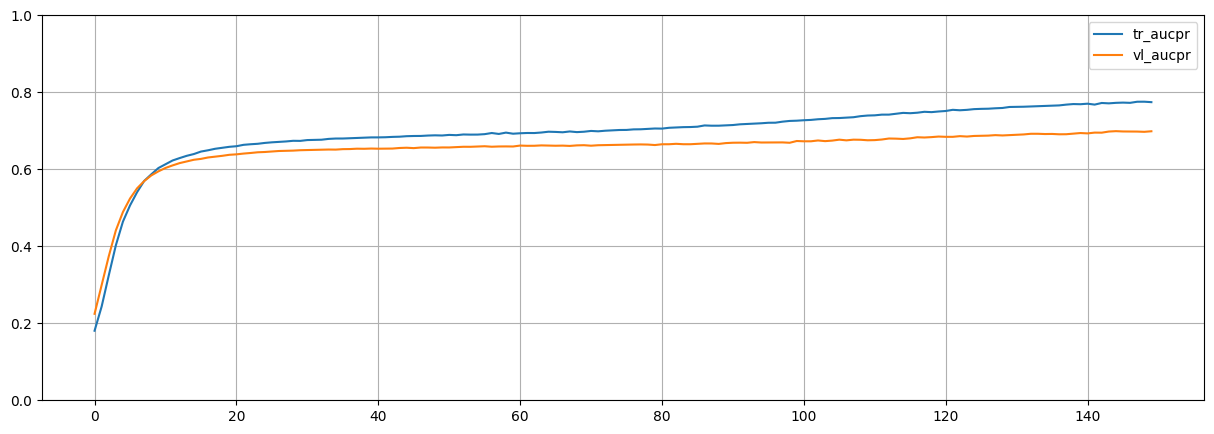

In [20]:
pd.DataFrame(main_metrics).plot(figsize = (15,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.legend(loc='upper right')
plt.show()

# Log no MLflow

In [22]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(10, activation='tanh', input_shape=X_treino2.shape[1:]),
        #keras.layers.Dropout(rate=.2),
        keras.layers.Dense(10, activation='tanh'),
        #keras.layers.Dropout(rate=.2),
        keras.layers.Dense(10, activation='tanh'),
        #keras.layers.Dropout(rate=.2),
        keras.layers.Dense(10, activation='tanh'),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(loss='binary_crossentropy',
              optimizer='sgd')
              #metrics=[keras.metrics.AUC(curve='PR'), tf.keras.metrics.F1Score, tf.keras.metrics.Precision, tf.keras.metrics.Recall])

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
experiment = mlflow.create_experiment(name = 'Modelo_MLP',
                                      artifact_location = 'Artf_Modelo_MLP',
                                      tags = {'Environment': 'Development', 'Version': '1.0.0'}
                                      )

In [27]:
experiment

'834278886258049761'

In [28]:
mlflow.tensorflow.autolog()

if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'MLP', experiment_id = experiment) as run: 

        model.fit(X_treino2, y_treino2, epochs=50, validation_data=(X_teste2, y_teste2), batch_size=32, callbacks=[mlflow.keras.MlflowCallback()])

2025/01/24 18:49:04 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2025/01/24 18:49:04 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/50
134/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5925

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5893 - val_loss: 0.4134
Epoch 2/50
119/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3961

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3964 - val_loss: 0.3763
Epoch 3/50
123/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3859

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3839 - val_loss: 0.3538
Epoch 4/50
122/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3500

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3496 - val_loss: 0.3393
Epoch 5/50
121/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3330

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3329 - val_loss: 0.3301
Epoch 6/50
128/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3361

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3353 - val_loss: 0.3242
Epoch 7/50
128/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3179

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3180 - val_loss: 0.3198
Epoch 8/50
128/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3202

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3196 - val_loss: 0.3171
Epoch 9/50
127/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3048

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3053 - val_loss: 0.3149
Epoch 10/50
116/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3159

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3151 - val_loss: 0.3133
Epoch 11/50
126/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3018

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3024 - val_loss: 0.3123
Epoch 12/50
127/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3072

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3071 - val_loss: 0.3112
Epoch 13/50
126/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2916

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2927 - val_loss: 0.3102
Epoch 14/50
134/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3078

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3076 - val_loss: 0.3094
Epoch 15/50
131/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3119

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3114 - val_loss: 0.3090
Epoch 16/50
108/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2948

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2961 - val_loss: 0.3082
Epoch 17/50
125/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2982

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2985 - val_loss: 0.3078
Epoch 18/50
132/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3040

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3038 - val_loss: 0.3073
Epoch 19/50
135/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3139

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3135 - val_loss: 0.3067
Epoch 20/50
128/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2830

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2842 - val_loss: 0.3062
Epoch 21/50
117/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3018

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3010 - val_loss: 0.3060
Epoch 22/50
123/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3054

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3046 - val_loss: 0.3051
Epoch 23/50
131/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2867

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2872 - val_loss: 0.3047
Epoch 24/50
127/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3082

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3073 - val_loss: 0.3042
Epoch 25/50
134/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2964

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2964 - val_loss: 0.3036
Epoch 26/50
133/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3027

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3023 - val_loss: 0.3032
Epoch 27/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2880

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2881 - val_loss: 0.3028
Epoch 28/50
133/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2966

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2964 - val_loss: 0.3025
Epoch 29/50
131/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2822

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2828 - val_loss: 0.3018
Epoch 30/50
133/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2974

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2972 - val_loss: 0.3011
Epoch 31/50
126/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2801

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2812 - val_loss: 0.3007
Epoch 32/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2888

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2888 - val_loss: 0.3003
Epoch 33/50
134/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2844

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2846 - val_loss: 0.2999
Epoch 34/50
129/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2900

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2899 - val_loss: 0.2994
Epoch 35/50
136/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2946

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2945 - val_loss: 0.2989
Epoch 36/50
134/138 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2942

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2940 - val_loss: 0.2983
Epoch 37/50
132/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3106

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3095 - val_loss: 0.2980
Epoch 38/50
128/138 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2856

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2858 - val_loss: 0.2975
Epoch 39/50
135/138 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2949

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2947 - val_loss: 0.2971
Epoch 40/50
121/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2920

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2909 - val_loss: 0.2969
Epoch 41/50
132/138 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2934

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2930 - val_loss: 0.2962
Epoch 42/50
129/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2753

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2760 - val_loss: 0.2955
Epoch 43/50
130/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2906

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2903 - val_loss: 0.2951
Epoch 44/50
126/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2765

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2772 - val_loss: 0.2947
Epoch 45/50
137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2804

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2804 - val_loss: 0.2940
Epoch 46/50
130/138 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2820

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2821 - val_loss: 0.2938
Epoch 47/50
129/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2774

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2777 - val_loss: 0.2931
Epoch 48/50
130/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2699

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2706 - val_loss: 0.2931
Epoch 49/50
135/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2745

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2747 - val_loss: 0.2923
Epoch 50/50
118/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2844

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2837 - val_loss: 0.2918


2025/01/24 18:49:35 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/01/24 18:49:35 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/01/24 18:49:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Aperfeiçoamento dos hiperparâmetros

In [52]:
def build_model(hp):

    model = keras.models.Sequential()

    #model.add(keras.layers.InputLayer(input_shape = X_treino2.shape[1:]))
    
    hp_filter1 = hp.Int('filters', min_value = 10, max_value = 20, step = 5)
    hp_actv1 = hp.Choice('ativacao', values = ['tanh', 'relu'])
    model.add(keras.layers.Dense(hp_filter1, activation=hp_actv1, input_shape=X_treino2.shape[1:]))

    hp_filter2 = hp.Int('filters', min_value = 10, max_value = 20, step = 5)
    hp_actv2 = hp.Choice('ativacao', values = ['tanh', 'relu'])
    model.add(keras.layers.Dense(hp_filter2, activation=hp_actv2))

    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    optimizer = keras.optimizers.Adam()

    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=[keras.metrics.AUC(curve='PR')])

    return model

In [54]:
tuner = BayesianOptimization(build_model, objective='val_loss', max_trials=5)
tuner.search(X_treino2, y_treino2, epochs = 10, validation_data = (X_teste2, y_teste2))

Trial 5 Complete [00h 00m 09s]
val_loss: 0.29284894466400146

Best val_loss So Far: 0.2694784998893738
Total elapsed time: 00h 00m 46s


In [72]:
best_hyperparameter = tuner.get_best_hyperparameters(1)[0]

In [59]:
print(tuner.get_best_hyperparameters(1)[0].values)

{'filters': 15, 'ativacao': 'relu'}


In [70]:
tuner.get_best_models(num_models=2)[0].summary()

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 15)             │           285 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541 (2.11 KB)

 Trainable params: 541 (2.11 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
tuner.get_best_models(num_models=2)[1].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 15)             │           285 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541 (2.11 KB)

 Trainable params: 541 (2.11 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
model = tuner.hypermodel.build(best_hyperparameter)
hystory = model.fit(X_treino2, y_treino2, epochs=50, validation_data=(X_teste2, y_teste2))

Epoch 1/50


/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc_2: 0.2592 - loss: 0.6840 - val_auc_2: 0.4842 - val_loss: 0.3928
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_2: 0.5075 - loss: 0.3824 - val_auc_2: 0.5787 - val_loss: 0.3410
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_2: 0.5596 - loss: 0.3215 - val_auc_2: 0.6180 - val_loss: 0.3168
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_2: 0.6167 - loss: 0.3132 - val_auc_2: 0.6433 - val_loss: 0.3013
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_2: 0.6427 - loss: 0.3022 - val_auc_2: 0.6598 - val_loss: 0.2920
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_2: 0.7014 - loss: 0.2816 - val_auc_2: 0.6687 - val_loss: 0.2864
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_2: 0.6599 - loss: 0.2846 - val_auc_2: 0.6772 - val_loss: 0.2821
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc_2: 0.7038 - loss: 0.2720 - val_auc_2: 0.6805 - val_loss: 0.2793
Epoch 9/50
138/138 ━━━━━━━━━━━━━━━━